# PGF modeling of the SIR in a well-mixed population

## Overview

### Introduction

In this notebook, we'll explore how we can use probability generation functions (PGFs) to simulate SIR models.

### References

- Antoine Allard, Laurent Hébert-Dufresne, Guillaume St-Onge. "Probability generating functions for computational epidemiology". https://cosmo-notes.github.io/pgfunk/chapters/index.html

## Introduction

### What are PGFs?

### Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import pandas as pd
from collections import Counter

In [ ]:
import cmocean

In [ ]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['text.usetex'] = False 
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

### Parameters

In [7]:
# SIR model setup
beta = 0.2
mu = 0.1

# Stochastic simulation
S_initial=1e4
I_initial=20
n_steps=200
n_sim=10000

N_pgf = 3000 # Support for PGF calculation (approximation)

In [8]:
beta/mu

2.0

### Probability Generating Function for SIR simulation

From Guillaume's slide (p110):

For SIR in a well-mixed population, we can use the following approximations in the early phase:

$$
\textrm{Bin}(S_t, \lambda_t) \simeq \textrm{Poisson}(S_t \lambda_t) \simeq \textrm{Poisson}(\beta I_t) = \sum_{i=1}^{I_t}\textrm{Poisson}(\beta)
$$

$$
\textrm{Bin}(I_t, \mu)  = \sum_{i=1}^{I_t}\textrm{Bern}(\mu)
$$

This approximation allows us to treat the SIR model as a branching process.

**Offspring Distribution:**  
$Q(x)$ is the probability generating function (PGF) for the offspring distribution, i.e., the number of new infections produced by a single infected individual.

$$
Q(x) = \big[ \mu + (1-\mu) x \big] \exp \big[ \beta (x-1) \big]
$$

**Total Infections $I_t$:**  
The total number of infections at time $t$, $I_t$, is obtained by the cumulative effect of these offspring over successive generations. This can be solved iteratively.

If we set the initial PGF as  
$$
G_0(x) = x^{I_{\text{initial}}},
$$
then the PGF for $I_t$ is given by the $t$-fold composition:
$$
G_t(x) = Q^{(t)}(x) \equiv Q\big(Q(\cdots Q(x) \cdots )\big)
$$


In [9]:
# PGF
Q = lambda x: ( mu + ((1-mu) *x) ) * np.exp(beta*(x-1))
G0 = lambda x: x**I_initial

# We use numerical inversion to get probability distribution from PGF
# https://cosmo-notes.github.io/pgfunk/chapters/numerical_inversion.html

n = np.arange(N_pgf)
c = np.exp(2*np.pi*1j*n/N_pgf)

# Iteratively solve for I_t using the offspring distribution
# G_{t+1}(x) = Q(G_t(x))
tset = range(0,n_steps+1)
x = c.copy()
pn_dict_pgf = {}
for t in range(max(tset)+1):
    if t in tset:
        pn = abs(np.fft.fft(G0(x))/N_pgf)
        pn_dict_pgf[t] = dict(zip(n, pn))
    x = Q(x)

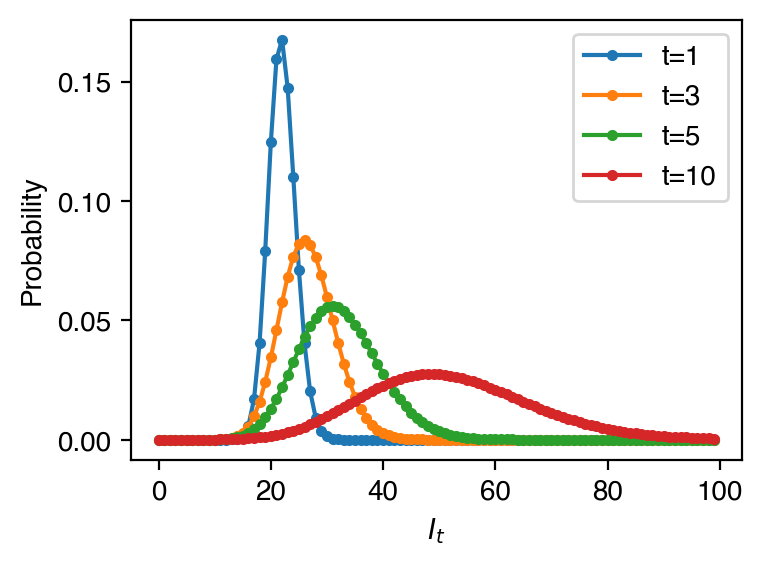

In [53]:
fig, ax = plt.subplots(1,1, figsize=(4,3))

for t in [1,3,5,10]:
    ax.plot(
        list(pn_dict_pgf[t].keys())[:100],
        list(pn_dict_pgf[t].values())[:100],
    	"o-",
        markersize=3,
        label=fr"t={t}"
    )

ax.set_title("", loc='left')
ax.set_xlabel("$I_t$")
ax.set_ylabel("Probability")

ax.legend(loc='upper right', frameon=True)

fig.tight_layout()
# plt.savefig('fig/fig_name.pdf', bbox_inches='tight')
plt.show()

In [14]:
# Calculate mean I_t for each timestep from probability distribution
# We'll compare with mean from stochastic simulation
It_mean_pgf = {}
for t, pn_dict in pn_dict_pgf.items():
	It_mean_pgf[t] = np.sum(
		np.prod([list(pn_dict.keys()), list(pn_dict.values())], axis=0)
	)

## Stochastic simulation

### Stochastic SIR

In [15]:
def SIR_model_stochastic(S_initial=1000, I_initial=1, R_initial=0, n_steps=1000, beta=0.4, gamma=0.4):
	"""
	Simulate SIR model.

	Parameters
	----------
	S_initial : int
		Initial number of susceptible individuals.
	I_initial : int
		Initial number of infected individuals.
	R_initial : int
		Initial number of recovered individuals.
	n_steps : int
		Number of steps to simulate.
	beta : float
		Infection rate (probability of infection on contact)
	gamma : float
		Recovery rate (probability of recovery per unit time)
	
	Returns
	-------
	S_dict : dict
		Dictionary with number of susceptible individuals at each time step.
		{t: S_t, ... }
	I_dict : dict
		Dictionary with number of infected individuals at each time step.
		{t: I_t, ... }
	R_dict : dict
		Dictionary with number of recovered individuals at each time step.
		{t: R_t, ... }
	df_data : list
		List of dictionary recording number of S, I, R at each timestep. This can be converted into a Pandas dataframe by pd.DataFrame(df_data).
		[ {'t': t, 'S': S_new, 'I': I_new, 'R': R_new}, ... ]
	"""

	# Set S,I,R to initial values
	S = S_initial
	I = I_initial
	R = R_initial

	# N is always constant
	N = S+I+R

	# Initialize dictionaries to store values
	# {t: S_t, ... } etc.
	# t=0 is the initial state
	S_dict = {0: S}
	I_dict = {0: I}
	R_dict = {0: R}
	df_data = [{'t': 0, 'S': S, 'I': I, 'R': R, 'lambda': beta*(I/N)}]

	# Start simulation from t=1 to t=n_steps
	for t in range(1, n_steps+1):

		# Calculate number of individuals for each compartment at next time step
		lambda_t = beta*(I/N)
		# lambda_t = beta*(I)

		# S_diff = np.random.poisson(lambda_t)
		S_diff = np.random.binomial(S, lambda_t)
		I_diff = np.random.binomial(I, gamma)

		S_new = S - S_diff
		I_new = I + S_diff - I_diff
		R_new = R + I_diff

		# Store values
		S_dict[t] = S_new
		I_dict[t] = I_new
		R_dict[t] = R_new
		
		# Data for pandas
		df_data.append({'t': t, 'S': S_new, 'I': I_new, 'R': R_new, 'lambda': lambda_t})
		
		# Update values for next time step
		S = S_new
		I = I_new
		R = R_new

	return S_dict, I_dict, R_dict, df_data

In [16]:
It_2darray_sim = []
sim_data = []

for it in trange(n_sim):

	# Run simulation
	_, I, _, df_list = SIR_model_stochastic(
		S_initial=S_initial,
		I_initial=I_initial,
		R_initial=0,
		n_steps=n_steps,
		beta=beta,
		gamma=mu
	)
	It_2darray_sim.append(list(I.values()))

	# For dataframe
	for item in df_list:
		item['iter'] = it
	sim_data.extend(df_list)

It_2darray_sim = np.array(It_2darray_sim).transpose()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1988.62it/s]


In [17]:
# Convert data to dataframe for summarization
df_sim = pd.DataFrame(sim_data)

In [18]:
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

In [19]:
It_summary = df_sim.groupby('t')['I'].agg(['median', 'mean', q25, q75])
It_summary

,median,mean,q25,q75
t,,,,
0,20.0,20.0000,20.0,20.0
1,22.0,22.0041,20.0,24.0
2,24.0,24.1956,22.0,27.0
3,26.0,26.6398,23.0,30.0
4,29.0,29.3089,25.0,33.0
...,...,...,...,...
196,1.0,1.1981,0.0,2.0
197,0.0,1.1262,0.0,2.0
198,0.0,1.0664,0.0,2.0


In [20]:
lambda_summary = df_sim.groupby('t')['lambda'].agg(['median', 'mean', q25, q75])

In [21]:
S_summary = df_sim.groupby('t')['S'].agg(['median', 'mean', q25, q75])

In [22]:
# St_summary = df_sim.groupby('t')['S'].agg(['median', 'mean', q25, q75])

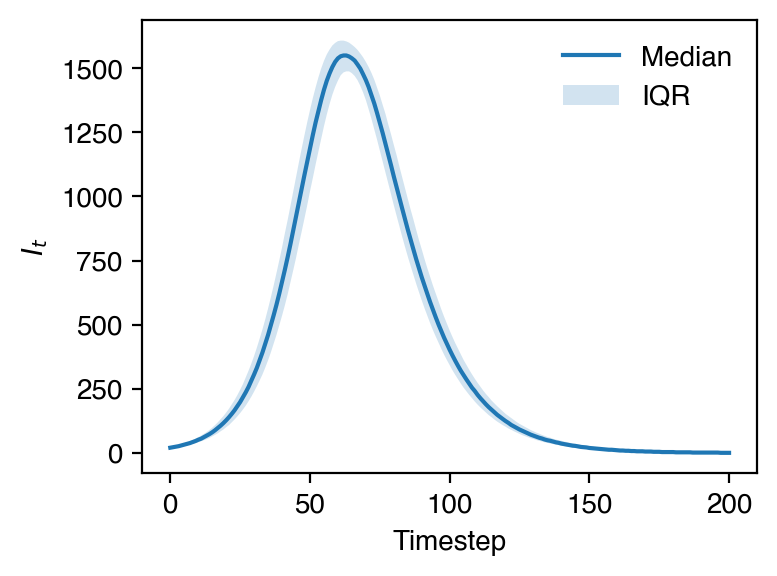

In [23]:
fig, ax = plt.subplots(1,1, figsize=(4,3))

# ax.plot(St_summary.index, St_summary['median'], label="S (Median)")
# ax.fill_between(St_summary.index, St_summary['q25'], St_summary['q75'], alpha=0.2)

ax.plot(It_summary.index, It_summary['median'], label="Median")
ax.fill_between(It_summary.index, It_summary['q25'], It_summary['q75'], alpha=0.2, label="IQR")

# ax.plot(Rt_summary.index, Rt_summary['median'], label="R (Median)")
# ax.fill_between(Rt_summary.index, Rt_summary['q25'], Rt_summary['q75'], alpha=0.2)


ax.set_title("", loc='left')
ax.set_xlabel("Timestep")
ax.set_ylabel("$I_t$")

ax.legend(loc='upper right', frameon=False)

fig.tight_layout()
# plt.savefig('fig/fig_name.pdf', bbox_inches='tight')
plt.show()

In [24]:
# Covert 2d array to dictionary by time
It_dict_sim = {t: It_2darray_sim[t] for t in range(len(It_2darray_sim))}

In [25]:
# Calculate probability for each t
pn_dict_sim = {}
for t, data in It_dict_sim.items():
	p_n = {int(It): It_count/len(data) for It, It_count in dict(Counter(It_dict_sim[t])).items() } # Count each I and calculate probability
	p_n = {k: p_n[k] for k in sorted(p_n)} # Sort by key
	pn_dict_sim[t] = p_n

## Comparison

### Probability distribution

In [26]:
cmap = cmocean.cm.ice

In [27]:
def zero_fill_prob_dist(dict, N):
    pn = {x: 0 for x in range(N)}
    for k, v in dict.items():
        pn[k] = v
    return pn

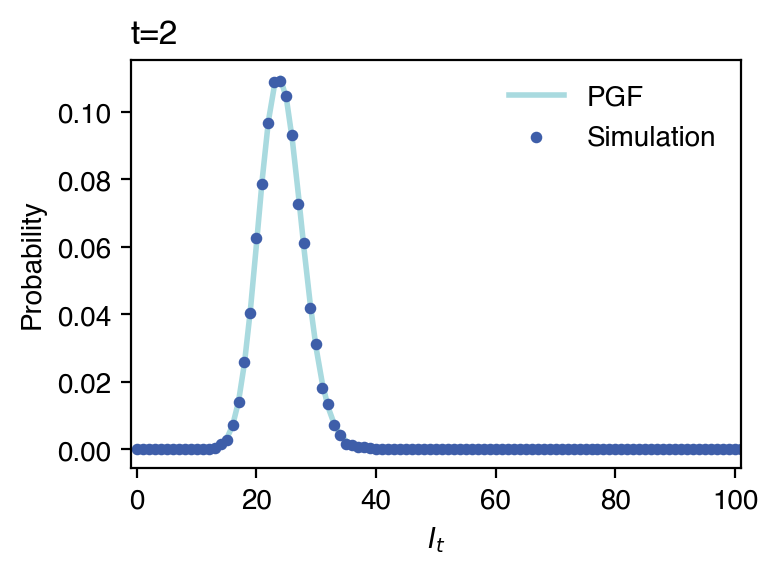

In [29]:
t_to_plot = 2
fig, ax = plt.subplots(1,1, figsize=(4,3))

ax.plot(pn_dict_pgf[t_to_plot].keys(), pn_dict_pgf[t_to_plot].values(), label="PGF", color=cmap(0.86), lw=2, zorder=-1)

ax.scatter(
    zero_fill_prob_dist(pn_dict_sim[t_to_plot], N_pgf).keys(),
	zero_fill_prob_dist(pn_dict_sim[t_to_plot], N_pgf).values(),
    # pn_dict_sim[t_to_plot].keys(), pn_dict_sim[t_to_plot].values(),
    label="Simulation", s=10, color=cmap(0.4)
)

ax.set_title(f"t={t_to_plot}", loc='left')
ax.set_ylabel("Probability")
ax.set_xlabel("$I_t$")

ax.set_xlim(-1, 100+1)

# ax.set_xscale('log')
# ax.set_yscale('log')

ax.legend(loc='upper right', frameon=False)

fig.tight_layout()
# plt.savefig('fig/fig_name.pdf', bbox_inches='tight')
plt.show()

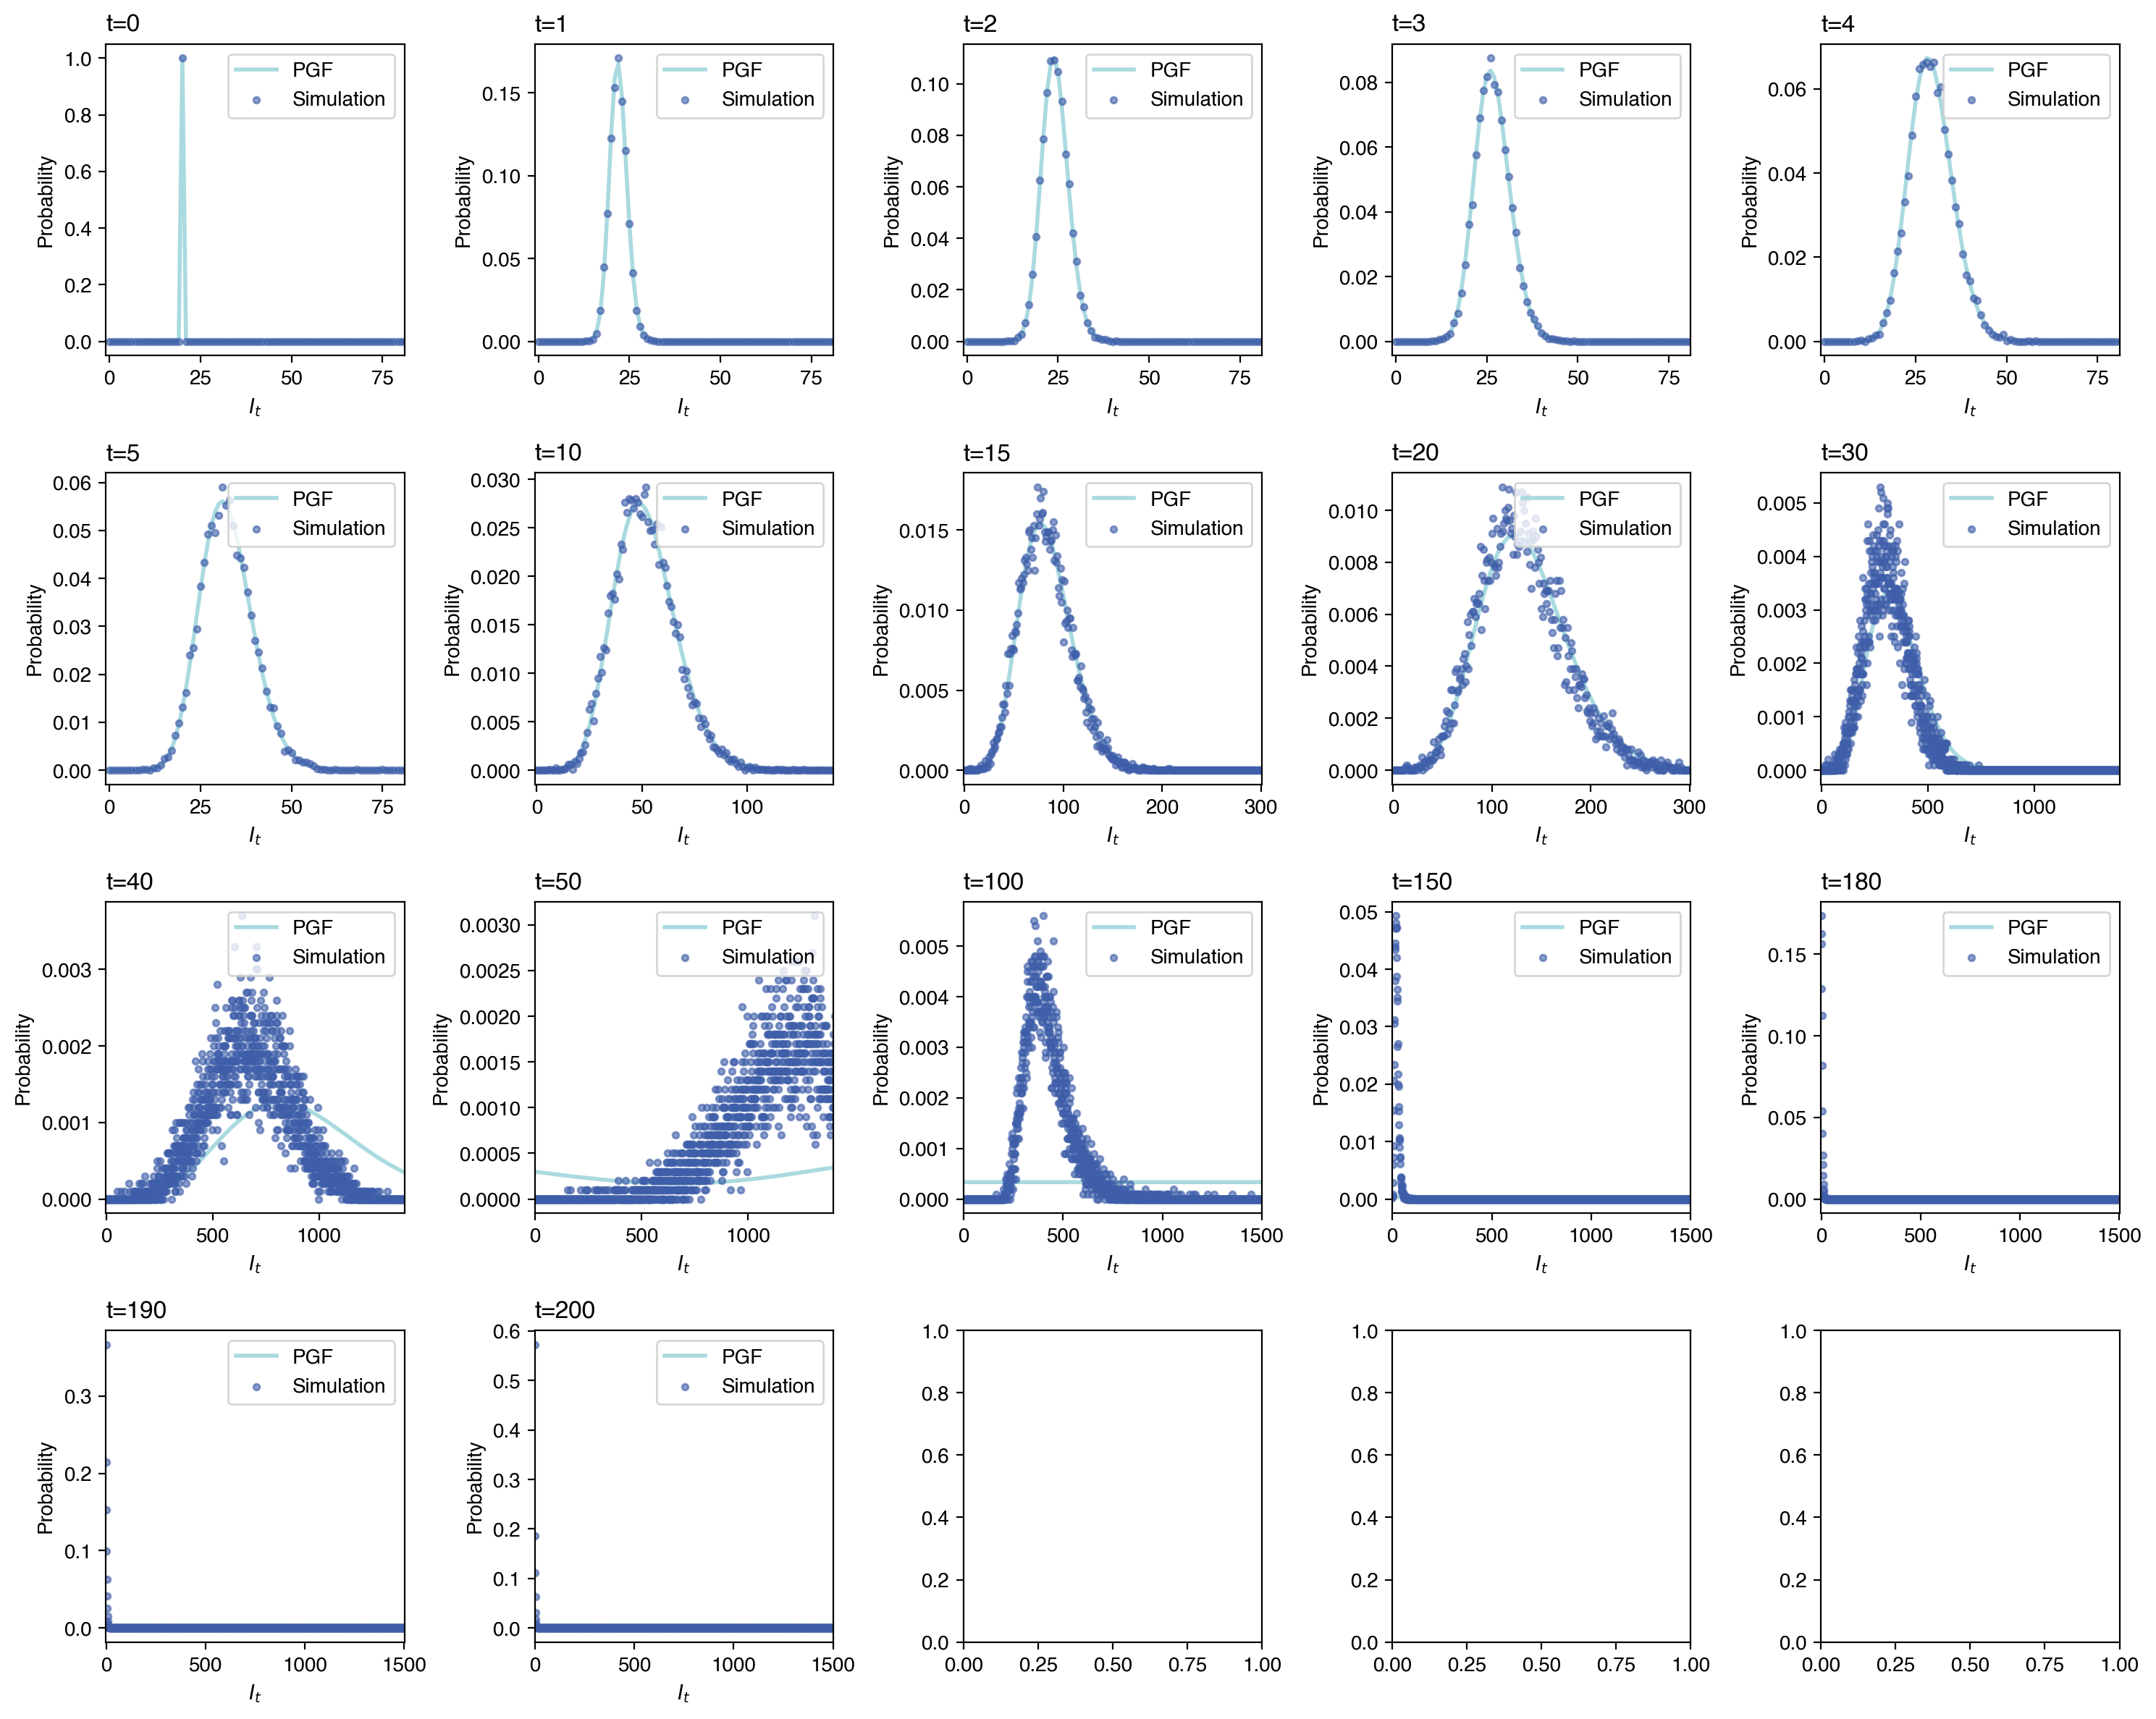

In [54]:
fig, axs = plt.subplots(4,5, figsize=(3*5,3*4))

axs_1d = axs.reshape(-1)

for i, t_ in enumerate([0,1,2,3,4,5,10,15,20,30,40,50,100,150,180,190,200]):
	ax = axs_1d[i]
	ax.plot(pn_dict_pgf[t_].keys(), pn_dict_pgf[t_].values(), label="PGF", color=cmap(0.86), lw=2, zorder=-1)

	ax.scatter(
		zero_fill_prob_dist(pn_dict_sim[t_], N_pgf).keys(),
		zero_fill_prob_dist(pn_dict_sim[t_], N_pgf).values(),
		label="Simulation", s=10, color=cmap(0.4),
		alpha=0.6
	)

	ax.set_title(f"t={t_}", loc='left')
	ax.set_ylabel("Probability")
	ax.set_xlabel("$I_t$")

	if t_ < 10:
		ax.set_xlim(-1, 80+1)
	elif t_ < 15:
		ax.set_xlim(-1, 140+1)
	elif t_ < 30:
		ax.set_xlim(-1, 300+1)
	elif t_ <= 50:
		ax.set_xlim(-1, 1400+1)
	else:
		ax.set_xlim(-1, 1500+1)
		
	# ax.set_xscale('log')
	# ax.set_yscale('log')

	ax.legend(loc='upper right', frameon=True)

fig.tight_layout()
	# plt.savefig('fig/fig_name.pdf', bbox_inches='tight')
plt.show()

### $I_t$ estimates

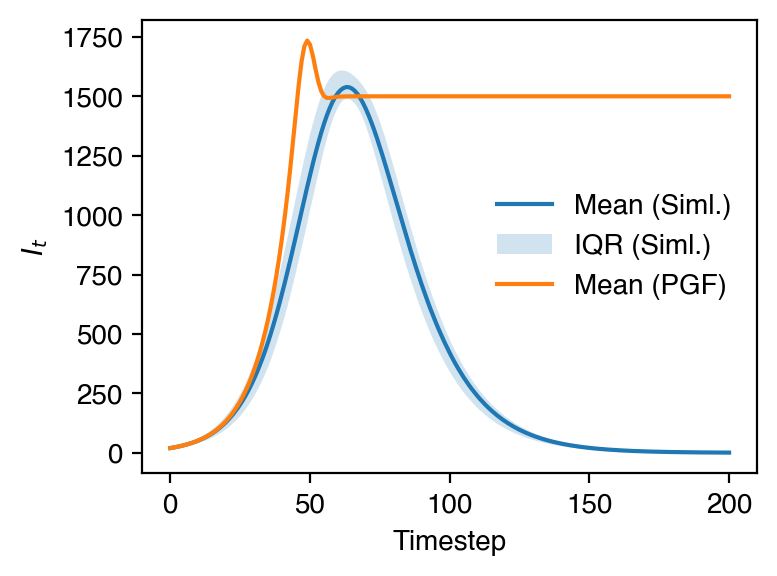

In [35]:
# Compare mean I_t from stochastic determinations and the expected value of the distribution derived from  PGF
# We can see that the PGF esimation which uses Poisson approximation is only valid for t \lessapprox 100 in this case. 
fig, ax = plt.subplots(1,1, figsize=(4,3))

ax.plot(It_summary.index, It_summary['mean'], label="Mean (Siml.)")
ax.fill_between(It_summary.index, It_summary['q25'], It_summary['q75'], alpha=0.2, label="IQR (Siml.)")

ax.plot(It_mean_pgf.keys(), It_mean_pgf.values(), label="Mean (PGF)")

ax.set_title("", loc='left')
ax.set_xlabel("Timestep")
ax.set_ylabel("$I_t$")

ax.legend(loc='center right', frameon=False)

fig.tight_layout()
# plt.savefig('fig/fig_name.pdf', bbox_inches='tight')
plt.show()

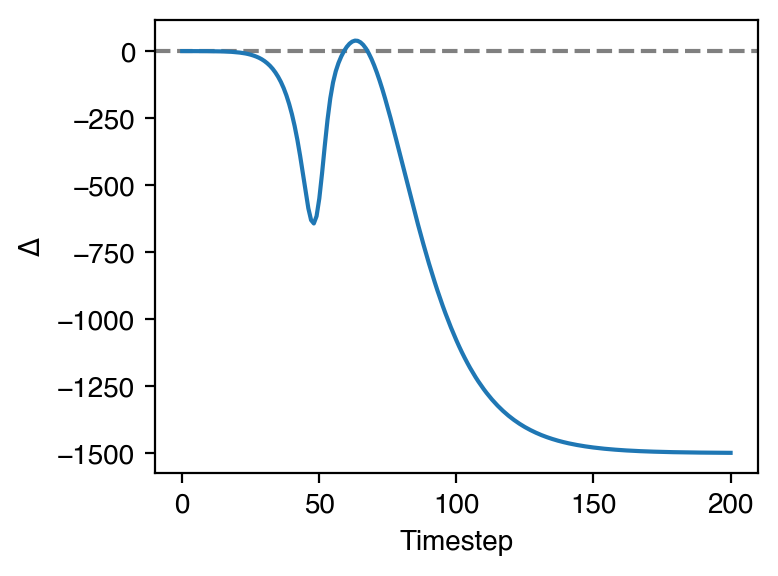

In [36]:
# Plot the difference between simulation and expected value from PGF method
fig, ax = plt.subplots(1,1, figsize=(4,3))

ax.plot(It_summary['mean'] - np.array(list(It_mean_pgf.values())))
ax.axhline(y=0, color='gray', linestyle='--', zorder=-1)

ax.set_title("", loc='left')

ax.set_xlabel("Timestep")
ax.set_ylabel(r"$\Delta$")

# ax.legend(loc='upper right', frameon=False)

fig.tight_layout()
# plt.savefig('fig/fig_name.pdf', bbox_inches='tight')
plt.show()

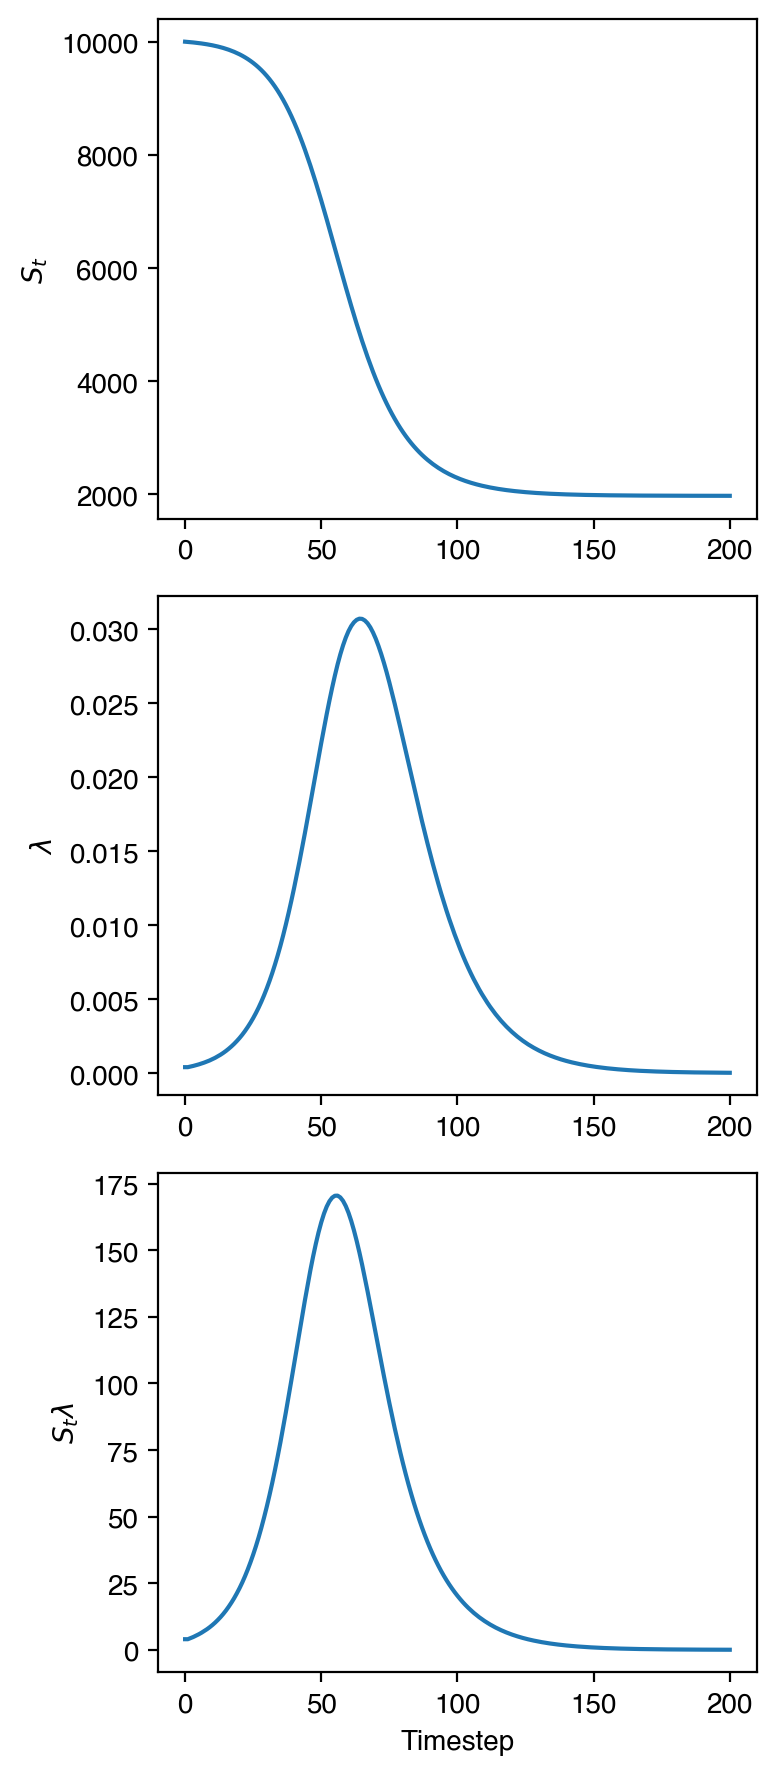

In [37]:
# This is because the Poisson approximation for Binomial distribution Bin(n,p) only holds when n is large and p is small.
# In this case, n and p corresponds to S_t and lambda.

fig, axs = plt.subplots(3,1, figsize=(4,3*3))
axs_1d = axs.reshape(-1)

axs_1d[0].plot(S_summary['mean'])
axs_1d[0].set_title("", loc='left')
axs_1d[0].set_xlabel("")
axs_1d[0].set_ylabel("$S_t$")

axs_1d[1].plot(lambda_summary['mean'])
axs_1d[1].set_title("", loc='left')
# axs_1d[1].set_xlabel("Timestep")
axs_1d[1].set_ylabel(r"$\lambda$")

axs_1d[2].plot(S_summary['mean'] * lambda_summary['mean'])
axs_1d[2].set_title("", loc='left')
axs_1d[2].set_xlabel("Timestep")
axs_1d[2].set_ylabel(r"$S_t \lambda$")

fig.tight_layout()
# plt.savefig('fig/fig_name.pdf', bbox_inches='tight')
plt.show()

### Jensen-Shannon divergence of distributions

In [38]:
from scipy.spatial.distance import jensenshannon as js_distance

In [39]:
js_distance_dict = {}
for t_ in trange(n_steps):
	N_simmax = max(pn_dict_sim[t_].keys())+1
	zerofillmax = max(N_pgf, N_simmax)
	js_distance_dict[t_] = js_distance(
		list(zero_fill_prob_dist(pn_dict_pgf[t_], zerofillmax).values()),
		list(zero_fill_prob_dist(pn_dict_sim[t_], zerofillmax).values())
    )

  0%|                                                                                                                                                                  | 0/200 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 713.62it/s]


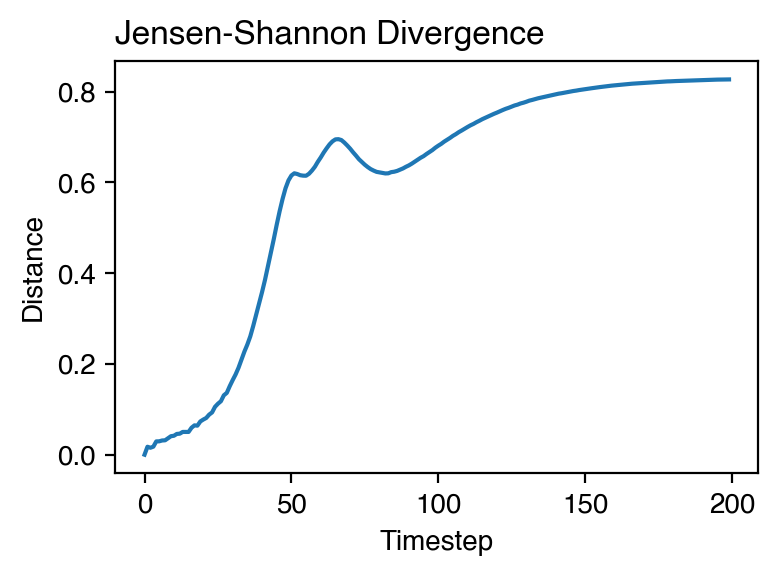

In [40]:
fig, ax = plt.subplots(1,1, figsize=(4,3))

ax.plot(
    js_distance_dict.keys(),
    js_distance_dict.values()
)

ax.set_title("Jensen-Shannon Divergence", loc='left')
ax.set_xlabel("Timestep")
ax.set_ylabel("Distance")

# ax.set_xlim(-1,50)

fig.tight_layout()
# plt.savefig('fig/fig_name.pdf', bbox_inches='tight')
plt.show()
